<a href="https://colab.research.google.com/github/Falconwatch/llm_course/blob/main/HW2/%D0%94%D0%972_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание ДЗ2.

В семинаре 5 предложите различные способы улучшения F1-score c помощью варьирования предобработки/моделей/количества обучаемых слоев в них и т.д.
**Используйте аналогичные данные и аналогичное разделение на подвыборки** (random_state зафиксирован у меня в семинаре).
В коде представьте ваш лучший подход к решению.

За задание можно получить максимум 10 баллов.

Разбалловка:
*   **Воспроизводимость и читабельность кода - 3 балла** (все воспроизвелось и все понятно для проверяющего - 3 балла; есть непонятные моменты, но все воспроизвелось - 2 балла; непонятный код и/или воспроизводится с небольшой правкой - 1 балл; непонятный код и/или ничего не воспроизвелось - 0 баллов).
*   **Технический отчет - 5 баллов** (за каждый описанный метод с полученной метрикой, при условии, что он корректный, 1 балл, соответственно для полного балла необходимо минимум 5 методов протестировать).
*   **Иновационность - 2 балла** (используете нетривиальную обработку/лосс-функцию/модель и можете объяснить свой результат - 2 балла; используете нетривиальную обработку/лосс-функцию/модель и не можете объяснить свой результат - 1 балл; просто перебираете модели из коробок - 0 баллов).

# 1. Информация о сабмите

**Щербаков Игорь Андреевич**

# 2. Технический отчет

В работе решил не перебирать множестов моделей, вместо этого посомтреть эффекты от разных подходов на одной модели. Из интереса сравнил две модели из коробки: rubert tiny2 против tuT5-small

Что было испробовано:
- Все эксперименты проводятся с использование фиксированного количества эпох - 20 - для обеспечения сравнимости результатов
- Заморозить/разморозить веса в модели BERT Tiny2
- Изменить подход к просталвению лейблов токенам в тексте: опробован подход с проставлением лейбло всем токенам, не только начальным - на примере Bert Tiny2
- Испробована другая модель - T5 Small, аналогично с заморозкой и разморозкой весов
- Опробован стратегия изменения LR reduce in plateu

**Важно:** результаты в таблице и на графике ниже приведены для прогона 20 эпох по каждому из экспериментов. Приведенные в выводах показатели могут немного отличаться от значений, приведённых в ячейках аутпутов ниже - из-за повторных прогонов.

**Таблица качества работы моделей**

Model| test_f1|	test_runtime
--- | --- | --- |
rubert_tiny_freezed|	0.039095|	0.7061
rubert_tiny_unfreezed|	0.674157|	0.7206
rubert_tiny_unfreezed_al|	0.663781|	0.7186
rubert_tiny_unfreezed_with_lrs|	0.732963|	0.6909
rut5-small|	0.491435|	1.5697
rut5-small-freezed|	0.017826|	1.6447




**График ошибки на тесте на обучении моделей в экспериментах**
Отрисован без замороженной Т5 чтобы было видно другие модели (масштаб)
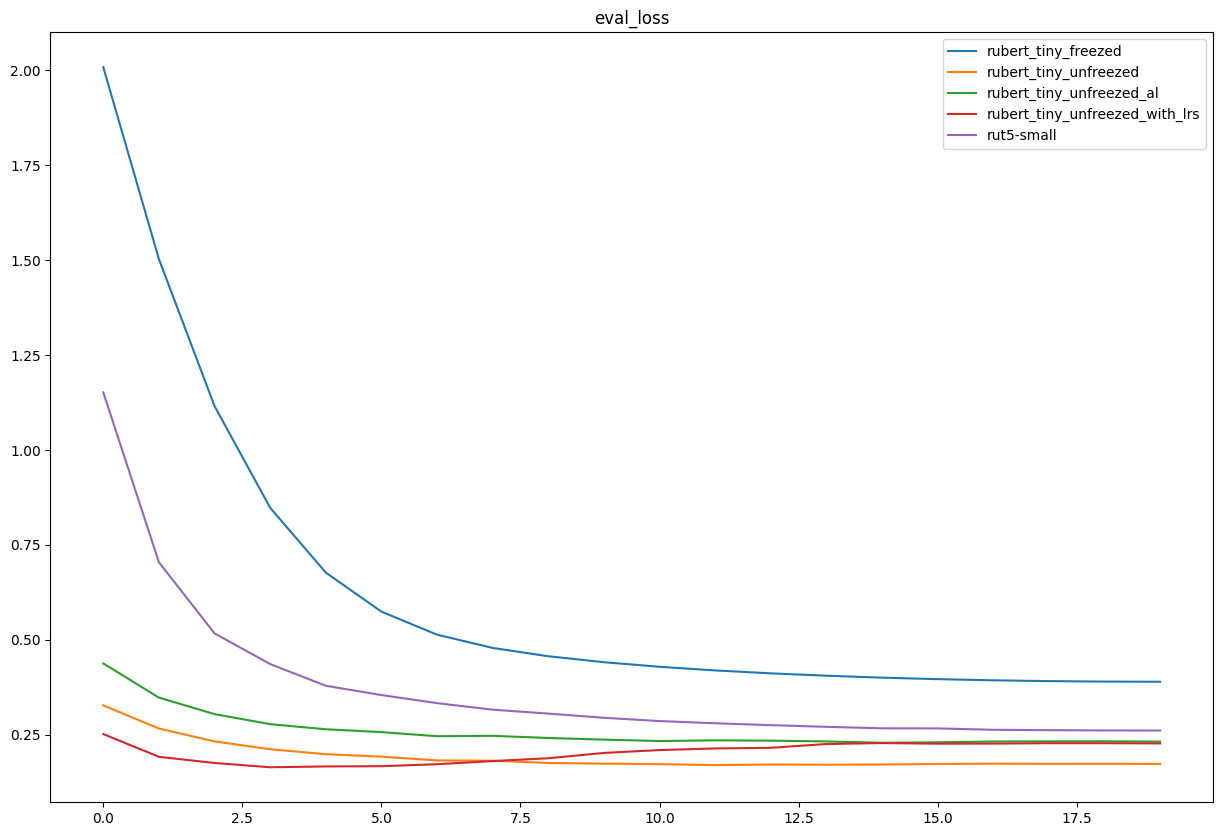


****
**Выводы:**
- Разморозка весов позитивно влияет на качество модели: f1 0.67 vs 0.04
- Расстановка лейблов на токены, кроме первых в слове, ухудшает качество: f1 0.66 vs 0.67
- добавление расписания изменения lr позитивно влияет на качество работы модели: f1 0.73 vs 0.67
- rut5-small из коробки показывает лучший результат, чем rubert_tiny: f1 0.49 vs 0.04
- Заморозка весов в трансформере T5 привела к очень большой просадке качества. Вероятно это связано с тем, что часть весов не подгрузилась из чек-поинта, о чём сообщает конструктор модели: "Some weights of MT5ForTokenClassification were not initialized from the model checkpoint"
- Т5 тяжелее на инференсе и обучении: вермя прогона теста в 2 разабольше, чем у bert tiny2


# 3. *Code*

## 3.1 Импорт библиотек

In [1]:
# some imports
!pip install -q Partial State
!pip install -q --upgrade accelerate
!pip install -q --upgrade transformers
!pip install datasets seqeval corus razdel -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.

In [2]:
from datasets import load_dataset, load_metric
from corus import load_rudrec
from razdel import tokenize
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from datasets import Dataset, DatasetDict
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
import transformers
import logging
from transformers.trainer import logger as noisy_logger

## 3.2 Загрузка данных

### 3.2.1 Загрузка в DatasetDict



In [3]:
# download the data
!wget https://github.com/cimm-kzn/RuDReC/raw/master/data/rudrec_annotated.json

--2024-07-16 18:42:43--  https://github.com/cimm-kzn/RuDReC/raw/master/data/rudrec_annotated.json
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cimm-kzn/RuDReC/master/data/rudrec_annotated.json [following]
--2024-07-16 18:42:44--  https://raw.githubusercontent.com/cimm-kzn/RuDReC/master/data/rudrec_annotated.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1773014 (1.7M) [text/plain]
Saving to: ‘rudrec_annotated.json’

rudrec_annotated.js 100%[===================>]   1.69M  --.-KB/s    in 0.01s   

2024-07-16 18:42:44 (129 MB/s) - ‘rudrec_annotated.json’ saved [1773014/1773014]



In [4]:
# Читаем датасет
drugs = list(load_rudrec('rudrec_annotated.json'))
print("Документов в корпусе", len(drugs))
print("Пример документа", drugs[0])
print("###############################")
print("посчитаем теги и их частоту...")
from collections import Counter, defaultdict
type2text = defaultdict(Counter)
ents = Counter()
for item in drugs:
    for e in item.entities:
        ents[e.entity_type] += 1
        type2text[e.entity_type][e.entity_text] += 1

for k, v in ents.most_common():
    print(k, v)
    print(type2text[k].most_common(3))


print("###############################")
print("Мэпим тэги на слова как в семинаре")
def extract_labels(item):
    raw_toks = list(tokenize(item.text))
    words = [tok.text for tok in raw_toks]
    word_labels = ['O'] * len(raw_toks)
    char2word = [None] * len(item.text)
    for i, word in enumerate(raw_toks):
        char2word[word.start:word.stop] = [i] * len(word.text)

    for e in item.entities:
        e_words = sorted({idx for idx in char2word[e.start:e.end] if idx is not None})
        word_labels[e_words[0]] = 'B-' + e.entity_type
        for idx in e_words[1:]:
            word_labels[idx] = 'I-' + e.entity_type

    return {'tokens': words, 'tags': word_labels}
print("На примере первого текста:")
print(extract_labels(drugs[0]))

print("Обрабатываем все тексты...")
ner_data = [extract_labels(item) for item in drugs]
ner_train, ner_test = train_test_split(ner_data, test_size=0.2, random_state=1)

print("Соберём все метки в список")
label_list = sorted({label for item in ner_train for label in item['tags']})
if 'O' in label_list:
    label_list.remove('O')
    label_list = ['O'] + label_list


print("Положим всё в DatasetDict")
ner_data = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame(ner_train)),
    'test': Dataset.from_pandas(pd.DataFrame(ner_test))
})
ner_data



Документов в корпусе 4809
Пример документа RuDReCRecord(file_name='172744.tsv', text='нам прописали, так мой ребенок сыпью покрылся, глаза опухли, сверху и снизу на веках высыпала сыпь, ( 8 месяцев сыну)А от виферона такого не было... У кого ещё такие побочки, отзовитесь!1 Чем спасались?\n', sentence_id=0, entities=[RuDReCEntity(entity_id='*[0]_se', entity_text='виферона', entity_type='Drugform', start=122, end=130, concept_id='C0021735', concept_name=nan), RuDReCEntity(entity_id='*[1]', entity_text='сыпью покрылся', entity_type='ADR', start=31, end=45, concept_id='C0015230', concept_name=nan), RuDReCEntity(entity_id='*[2]', entity_text='глаза опухли', entity_type='ADR', start=47, end=59, concept_id='C4760994', concept_name=nan), RuDReCEntity(entity_id='*[3]', entity_text='на веках высыпала сыпь', entity_type='ADR', start=76, end=98, concept_id='C0015230', concept_name=nan)])
###############################
посчитаем теги и их частоту...
DI 1401
[('простуды', 64), ('ОРВИ', 47), ('профи

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 3847
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 962
    })
})

### 3.2.2 Препроцессим

In [5]:
def tokenize_and_align_labels_common(examples, tokenizer, label_all_tokens=False):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples['tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        label_ids = [label_list.index(idx) if isinstance(idx, str) else idx for idx in label_ids]

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

## 3.3. Модель

In [6]:
EPOCHS = 20

In [7]:
MODELS_DICT = dict()
def add_model(model, name):
  model_dict = dict()
  model_dict['model'] = model
  MODELS_DICT[name] = model_dict

def add_result(result, name):
  if name in MODELS_DICT:
    MODELS_DICT[name]["result"] = result
  else:
    raise BaseException("Нет модели с таким именем в списке")

def add_trainer(trainer, name):
  if name in MODELS_DICT:
    MODELS_DICT[name]["trainer"] = trainer
  else:
    raise BaseException("Нет модели с таким именем в списке")

In [8]:
noisy_logger.setLevel(logging.WARNING)

In [9]:
metric = load_metric("seqeval", trust_remote_code=True)

<ipython-input-9-5871355ace1c>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval", trust_remote_code=True)


In [10]:
def compute_metrics_common(p, tokenizer):
    predictions, labels, inputs = p.predictions, p.label_ids, p.inputs
    predictions = np.argmax(p.predictions, axis=2)

    # send only the first token of each word to the evaluation
    true_predictions = []
    true_labels = []
    for prediction, label, tokens in zip(predictions, labels, inputs):
        true_predictions.append([])
        true_labels.append([])
        for (p, l, t) in zip(prediction, label, tokens):
            if l != -100 and not tokenizer.convert_ids_to_tokens(int(t)).startswith('##'):
                true_predictions[-1].append(label_list[p])
                true_labels[-1].append(label_list[l])

    results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=0)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

### 3.3.1 Rubert Tiny2 Freezed
Модель с замороженными весами

In [11]:
rubert_tiny_checkpoint = "cointegrated/rubert-tiny2"
batch_size = 16

In [12]:
rt_tokenizer = AutoTokenizer.from_pretrained(rubert_tiny_checkpoint)

def compute_metrics_rt(p):
  return compute_metrics_common(p, rt_tokenizer)

def tokenize_and_align_labels_rt(examples,label_all_tokens=False):
  return tokenize_and_align_labels_common(examples=examples,
                                          tokenizer=rt_tokenizer,
                                          label_all_tokens = label_all_tokens
                                          )

rt_tokenized_datasets = ner_data.map(tokenize_and_align_labels_rt, batched=True)
rt_data_collator = DataCollatorForTokenClassification(rt_tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/3847 [00:00<?, ? examples/s]

Map:   0%|          | 0/962 [00:00<?, ? examples/s]

In [13]:
rubert_tiny_freezed = AutoModelForTokenClassification.from_pretrained(rubert_tiny_checkpoint,
                                                                      num_labels=len(label_list),
                                                                      device_map = 'cuda')
rubert_tiny_freezed.config.id2label = dict(enumerate(label_list))
rubert_tiny_freezed.config.label2id = {v: k for k, v in rubert_tiny_freezed.config.id2label.items()}


for param in rubert_tiny_freezed.bert.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
rt_args = TrainingArguments(
    "ner",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    save_strategy='no',
    report_to='none',
    include_inputs_for_metrics=True,
)

# model training
rtf_trainer = Trainer(
    rubert_tiny_freezed,
    rt_args,
    train_dataset=rt_tokenized_datasets["train"],
    eval_dataset=rt_tokenized_datasets["test"],
    data_collator=rt_data_collator,
    tokenizer=rt_tokenizer,
    compute_metrics=compute_metrics_rt
)

In [15]:
rtf_trainer.evaluate()
rtf_trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,2.007979,0.011141,0.034884,0.016888,0.685529
2,No log,1.502675,0.040404,0.008457,0.013986,0.889414
3,2.005800,1.115618,0.071429,0.001057,0.002083,0.900199
4,2.005800,0.847797,0.000000,0.000000,0.000000,0.900864
5,1.104600,0.677101,0.000000,0.000000,0.000000,0.900864
6,1.104600,0.574312,0.000000,0.000000,0.000000,0.900864
7,0.662300,0.513614,0.000000,0.000000,0.000000,0.900864
8,0.662300,0.478706,0.000000,0.000000,0.000000,0.900864
9,0.495900,0.456829,0.000000,0.000000,0.000000,0.900864
10,0.495900,0.441176,0.000000,0.000000,0.000000,0.900864


TrainOutput(global_step=4820, training_loss=0.6758414873938343, metrics={'train_runtime': 72.7372, 'train_samples_per_second': 1057.781, 'train_steps_per_second': 66.266, 'total_flos': 49424108009730.0, 'train_loss': 0.6758414873938343, 'epoch': 20.0})

In [16]:
rtf_predictions = rtf_trainer.predict(rt_tokenized_datasets["test"])

add_model(rubert_tiny_freezed, "rubert_tiny_freezed")
add_result(rtf_predictions.metrics, "rubert_tiny_freezed")
add_trainer(rtf_trainer, "rubert_tiny_freezed")

### 3.3.2 Rubert Tiny2 Unfreezed
Rubert Tiny2 с размороженными весами. Остальное неизменно

In [17]:
rubert_tiny_unfreezed = AutoModelForTokenClassification.from_pretrained(rubert_tiny_checkpoint,
                                                                        num_labels=len(label_list),
                                                                        device_map = 'cuda')
rubert_tiny_unfreezed.config.id2label = dict(enumerate(label_list))
rubert_tiny_unfreezed.config.label2id = {v: k for k, v in rubert_tiny_unfreezed.config.id2label.items()}


for param in rubert_tiny_unfreezed.bert.parameters():
    param.requires_grad = True

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
rtuf_trainer = Trainer(
    rubert_tiny_unfreezed,
    rt_args,
    train_dataset=rt_tokenized_datasets["train"],
    eval_dataset=rt_tokenized_datasets["test"],
    data_collator=rt_data_collator,
    tokenizer=rt_tokenizer,
    compute_metrics=compute_metrics_rt
)

In [19]:
rtuf_trainer.evaluate()
rtuf_trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.327340,0.492625,0.353066,0.411330,0.923100
2,No log,0.266462,0.480331,0.490486,0.485356,0.931152
3,0.450000,0.232532,0.513171,0.556025,0.533739,0.937135
4,0.450000,0.211932,0.552195,0.598309,0.574328,0.943562
5,0.203900,0.198811,0.560409,0.637421,0.596439,0.946000
6,0.203900,0.192380,0.566308,0.668076,0.612997,0.947994
7,0.159300,0.182472,0.585952,0.670190,0.625247,0.948807
8,0.159300,0.181764,0.569218,0.699789,0.627786,0.949472
9,0.128300,0.175677,0.612523,0.713531,0.659180,0.952944
10,0.128300,0.174024,0.617060,0.718816,0.664062,0.953830


TrainOutput(global_step=4820, training_loss=0.14853821196496733, metrics={'train_runtime': 134.7828, 'train_samples_per_second': 570.844, 'train_steps_per_second': 35.761, 'total_flos': 49424108009730.0, 'train_loss': 0.14853821196496733, 'epoch': 20.0})

In [20]:
rtuf_predictions = rtuf_trainer.predict(rt_tokenized_datasets["test"])

add_model(rubert_tiny_unfreezed, "rubert_tiny_unfreezed")
add_result(rtuf_predictions.metrics, "rubert_tiny_unfreezed")
add_trainer(rtuf_trainer, "rubert_tiny_unfreezed")

### 3.3.3 RT2 Unfreezed + all labled
Rubert Tiny2 с размороженными весами и проставлением лейблов для всех токенов, не только первых в слове

In [21]:
rubert_tiny_unfreezed_al = AutoModelForTokenClassification.from_pretrained(rubert_tiny_checkpoint,
                                                                        num_labels=len(label_list),
                                                                        device_map = 'cuda')
rubert_tiny_unfreezed_al.config.id2label = dict(enumerate(label_list))
rubert_tiny_unfreezed_al.config.label2id = {v: k for k, v in rubert_tiny_unfreezed_al.config.id2label.items()}


for param in rubert_tiny_unfreezed_al.bert.parameters():
    param.requires_grad = True

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Делаю вызов токениpации, лейблы ставлю всем токенам
def tokenize_and_align_labels_rt_al(examples):
  return tokenize_and_align_labels_common(examples=examples,
                                          tokenizer=rt_tokenizer,
                                          label_all_tokens = True
                                          )

In [23]:
rt_tokenized_datasets_al = ner_data.map(tokenize_and_align_labels_rt_al, batched=True)

Map:   0%|          | 0/3847 [00:00<?, ? examples/s]

Map:   0%|          | 0/962 [00:00<?, ? examples/s]

In [24]:
rtuf_trainer_al = Trainer(
    rubert_tiny_unfreezed_al,
    rt_args,
    train_dataset=rt_tokenized_datasets_al["train"],
    eval_dataset=rt_tokenized_datasets_al["test"],
    data_collator=rt_data_collator,
    tokenizer=rt_tokenizer,
    compute_metrics=compute_metrics_rt
)

In [25]:
rtuf_trainer_al.evaluate()
rtuf_trainer_al.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.437831,0.503425,0.304663,0.379600,0.921009
2,No log,0.347888,0.505051,0.466321,0.484914,0.930937
3,0.561700,0.304395,0.506161,0.553368,0.528713,0.935648
4,0.561700,0.277957,0.532516,0.585492,0.557749,0.940865
5,0.278500,0.264519,0.520889,0.607254,0.560766,0.941735
6,0.278500,0.256975,0.529870,0.634197,0.577358,0.943692
7,0.216900,0.246227,0.562274,0.645596,0.601061,0.946011
8,0.216900,0.247213,0.540201,0.668394,0.597499,0.945866
9,0.176000,0.241570,0.567126,0.682902,0.619652,0.948112
10,0.176000,0.237218,0.586328,0.693264,0.635328,0.949054


TrainOutput(global_step=4820, training_loss=0.19966798521176413, metrics={'train_runtime': 130.0904, 'train_samples_per_second': 591.435, 'train_steps_per_second': 37.051, 'total_flos': 49424108009730.0, 'train_loss': 0.19966798521176413, 'epoch': 20.0})

In [26]:
rtuf_al_predictions = rtuf_trainer_al.predict(rt_tokenized_datasets_al["test"])

add_model(rubert_tiny_unfreezed_al, "rubert_tiny_unfreezed_al")
add_result(rtuf_al_predictions.metrics, "rubert_tiny_unfreezed_al")
add_trainer(rtuf_trainer_al, "rubert_tiny_unfreezed_al")

### 3.3.4 RT2 unfreezed + LRS
Rubert tiny2 с размороженными весами, лейблы только на первых токенах в словах. Убывающий LR по правилу reduce_lr_on_plateau

In [27]:
rtu_lrs = AutoModelForTokenClassification.from_pretrained(rubert_tiny_checkpoint,
                                                                        num_labels=len(label_list),
                                                                        device_map = 'cuda')
rtu_lrs.config.id2label = dict(enumerate(label_list))
rtu_lrs.config.label2id = {v: k for k, v in rtu_lrs.config.id2label.items()}


for param in rtu_lrs.bert.parameters():
    param.requires_grad = True

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
rtu_lrs_args = TrainingArguments(
    "ner",
    eval_strategy = "epoch",
    lr_scheduler_type = "reduce_lr_on_plateau",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    save_strategy='no',
    report_to='none',
    include_inputs_for_metrics=True,
)

rtu_lrs_trainer = Trainer(
    rtu_lrs,
    rtu_lrs_args,
    train_dataset=rt_tokenized_datasets["train"],
    eval_dataset=rt_tokenized_datasets["test"],
    data_collator=rt_data_collator,
    tokenizer=rt_tokenizer,
    compute_metrics=compute_metrics_rt
)

In [29]:
rtu_lrs_trainer.evaluate()
rtu_lrs_trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.251867,0.508021,0.502114,0.505051,0.933516
2,No log,0.191940,0.575931,0.637421,0.605118,0.946517
3,0.312100,0.175712,0.576430,0.713531,0.637695,0.948438
4,0.312100,0.164395,0.651760,0.724101,0.686029,0.957302
5,0.120700,0.166573,0.664789,0.748414,0.704127,0.959075
6,0.120700,0.167242,0.674618,0.747357,0.709127,0.960109
7,0.071000,0.172479,0.700488,0.758985,0.728564,0.961439
8,0.071000,0.180766,0.704457,0.768499,0.735086,0.960996
9,0.041100,0.188173,0.690291,0.751586,0.719636,0.960626
10,0.041100,0.202197,0.682811,0.760042,0.719360,0.958780


TrainOutput(global_step=4820, training_loss=0.06358370068656953, metrics={'train_runtime': 130.3216, 'train_samples_per_second': 590.386, 'train_steps_per_second': 36.985, 'total_flos': 49424108009730.0, 'train_loss': 0.06358370068656953, 'epoch': 20.0})

In [30]:
rtu_lrs_predictions = rtu_lrs_trainer.predict(rt_tokenized_datasets["test"])

add_model(rtu_lrs, "rubert_tiny_unfreezed_with_lrs")
add_result(rtu_lrs_predictions.metrics, "rubert_tiny_unfreezed_with_lrs")
add_trainer(rtu_lrs_trainer, "rubert_tiny_unfreezed_with_lrs")

### 3.3.5 T5 small
- T5 small из коробки
- Лейблы только на первых токенах
- Веса разморожены

In [31]:
t5_checkpoint = "cointegrated/rut5-small"
batch_size = 16

In [32]:
t5_tokenizer = AutoTokenizer.from_pretrained(t5_checkpoint)

def compute_metrics_t5(p):
  return compute_metrics_common(p, t5_tokenizer)

def tokenize_and_align_labels_t5(examples,label_all_tokens=False):
  return tokenize_and_align_labels_common(examples=examples,
                                          tokenizer=t5_tokenizer,
                                          )

t5_tokenized_datasets = ner_data.map(tokenize_and_align_labels_t5, batched=True)
t5_data_collator = DataCollatorForTokenClassification(t5_tokenizer)

tokenizer_config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/640k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/3847 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/962 [00:00<?, ? examples/s]

In [33]:
t5 = AutoModelForTokenClassification.from_pretrained(t5_checkpoint,
                                                       num_labels=len(label_list),
                                                       device_map="cuda"
                                 )
t5.config.id2label = dict(enumerate(label_list))
t5.config.label2id = {v: k for k, v in t5.config.id2label.items()}


model.safetensors:   0%|          | 0.00/259M [00:00<?, ?B/s]

Some weights of MT5ForTokenClassification were not initialized from the model checkpoint at cointegrated/rut5-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
t5_args = TrainingArguments(
    "ner",
    eval_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    save_strategy='no',
    report_to='none',
    include_inputs_for_metrics=True,
)

t5_trainer = Trainer(
    t5,
    t5_args,
    train_dataset=t5_tokenized_datasets["train"],
    eval_dataset=t5_tokenized_datasets["test"],
    data_collator=t5_data_collator,
    tokenizer=t5_tokenizer,
    compute_metrics=compute_metrics_t5
)

In [35]:
t5_trainer.evaluate()
t5_trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.151682,0.079696,0.044397,0.057026,0.881067
2,No log,0.704223,0.226923,0.124736,0.160982,0.898796
3,2.026200,0.517025,0.352851,0.242072,0.287147,0.909581
4,2.026200,0.436228,0.406380,0.309725,0.351530,0.916230
5,0.623900,0.379103,0.404790,0.357294,0.379562,0.918889
6,0.623900,0.354604,0.440955,0.371036,0.402985,0.922287
7,0.472300,0.333345,0.464858,0.398520,0.429141,0.924355
8,0.472300,0.316057,0.459649,0.415433,0.436424,0.925907
9,0.400600,0.305821,0.476079,0.431290,0.452579,0.927827
10,0.400600,0.294750,0.480549,0.443975,0.461538,0.928640


TrainOutput(global_step=4820, training_loss=0.5587029658907182, metrics={'train_runtime': 372.2069, 'train_samples_per_second': 206.713, 'train_steps_per_second': 12.95, 'total_flos': 610126242629904.0, 'train_loss': 0.5587029658907182, 'epoch': 20.0})

In [36]:
t5_predictions = t5_trainer.predict(t5_tokenized_datasets["test"])

add_model(t5, "rut5-small")
add_result(t5_predictions.metrics, "rut5-small")
add_trainer(t5_trainer, "rut5-small")

### 3.3.6 T5 Small freezed
- T5 small из коробки
- Лейблы только на первых токенах
- Веса заморожены

In [37]:
t5_freezed = AutoModelForTokenClassification.from_pretrained(t5_checkpoint,
                                                       num_labels=len(label_list),
                                                       device_map="cuda"
                                 )

t5_freezed.config.id2label = dict(enumerate(label_list))
t5_freezed.config.label2id = {v: k for k, v in t5_freezed.config.id2label.items()}

for param in t5_freezed.transformer.encoder.parameters():
  param.requires_grad = False

Some weights of MT5ForTokenClassification were not initialized from the model checkpoint at cointegrated/rut5-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
t5f_trainer = Trainer(
    t5_freezed,
    t5_args,
    train_dataset=t5_tokenized_datasets["train"],
    eval_dataset=t5_tokenized_datasets["test"],
    data_collator=t5_data_collator,
    tokenizer=t5_tokenizer,
    compute_metrics=compute_metrics_t5
)

In [39]:
t5f_trainer.evaluate()
t5f_trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,8.840000,0.009232,0.115222,0.017094,0.080889
2,No log,8.682754,0.009273,0.115222,0.017165,0.085396
3,9.417000,8.535052,0.009413,0.116279,0.017416,0.090567
4,9.417000,8.396942,0.009457,0.116279,0.017491,0.095294
5,9.123000,8.268066,0.009507,0.116279,0.017576,0.099801
6,9.123000,8.148486,0.009569,0.116279,0.017682,0.105710
7,8.848800,8.037930,0.009607,0.116279,0.017748,0.109108
8,8.848800,7.936327,0.009656,0.116279,0.017831,0.113024
9,8.633300,7.843432,0.009608,0.115222,0.017737,0.116717
10,8.633300,7.759280,0.009642,0.115222,0.017794,0.119967


TrainOutput(global_step=4820, training_loss=8.500950780844788, metrics={'train_runtime': 155.1722, 'train_samples_per_second': 495.836, 'train_steps_per_second': 31.062, 'total_flos': 610126242629904.0, 'train_loss': 8.500950780844788, 'epoch': 20.0})

In [40]:
t5f_predictions = t5f_trainer.predict(t5_tokenized_datasets["test"])

add_model(t5_freezed, "rut5-small-freezed")
add_result(t5f_predictions.metrics, "rut5-small-freezed")
add_trainer(t5f_trainer, "rut5-small-freezed")

## 3.4. Применение модели

In [41]:
# model inference

In [42]:
results = list()
learing_hists = list()
for k in MODELS_DICT.keys():
  tmp = MODELS_DICT[k]["result"]
  results.append(pd.DataFrame.from_records(tmp, index=[k]))

  learning_history = pd.DataFrame(MODELS_DICT[k]["trainer"].state.log_history)
  learing_hists.append([k, learning_history])


results_table = pd.concat(results)

In [43]:
results_table

,test_accuracy,test_f1,test_loss,test_precision,test_recall,test_runtime,test_samples_per_second,test_steps_per_second
rubert_tiny_freezed,0.902342,0.039095,0.389643,0.730769,0.020085,0.7061,1362.327,86.385
rubert_tiny_unfreezed,0.955308,0.674157,0.173282,0.626703,0.729387,0.7206,1335.073,84.656
rubert_tiny_unfreezed_al,0.953330,0.663781,0.232004,0.619390,0.715026,0.7186,1338.782,84.892
rubert_tiny_unfreezed_with_lrs,0.961587,0.732963,0.227313,0.701449,0.767442,0.6909,1392.332,88.287
rut5-small,0.932925,0.491435,0.261171,0.497831,0.485201,1.5697,612.850,38.861
rut5-small-freezed,0.138731,0.017826,7.365371,0.009675,0.113108,1.6447,584.914,37.089


### 3.4.1 Сравнение качества и скорости инференса

In [44]:
results_table[["test_f1", "test_runtime"]]

,test_f1,test_runtime
rubert_tiny_freezed,0.039095,0.7061
rubert_tiny_unfreezed,0.674157,0.7206
rubert_tiny_unfreezed_al,0.663781,0.7186
rubert_tiny_unfreezed_with_lrs,0.732963,0.6909
rut5-small,0.491435,1.5697
rut5-small-freezed,0.017826,1.6447


### 3.4.2 Сравнение графиков обучения

In [45]:
hists_renamed = list()
for lh in learing_hists:
  hist = lh[1][["eval_loss"]].dropna().reset_index().drop("index", axis=1)
  name = lh[0]
  hist.rename({"eval_loss":name}, inplace=True,axis=1)
  hists_renamed.append(hist)
full_hist = pd.concat(hists_renamed,axis=1)


<Axes: title={'center': 'eval_loss'}>

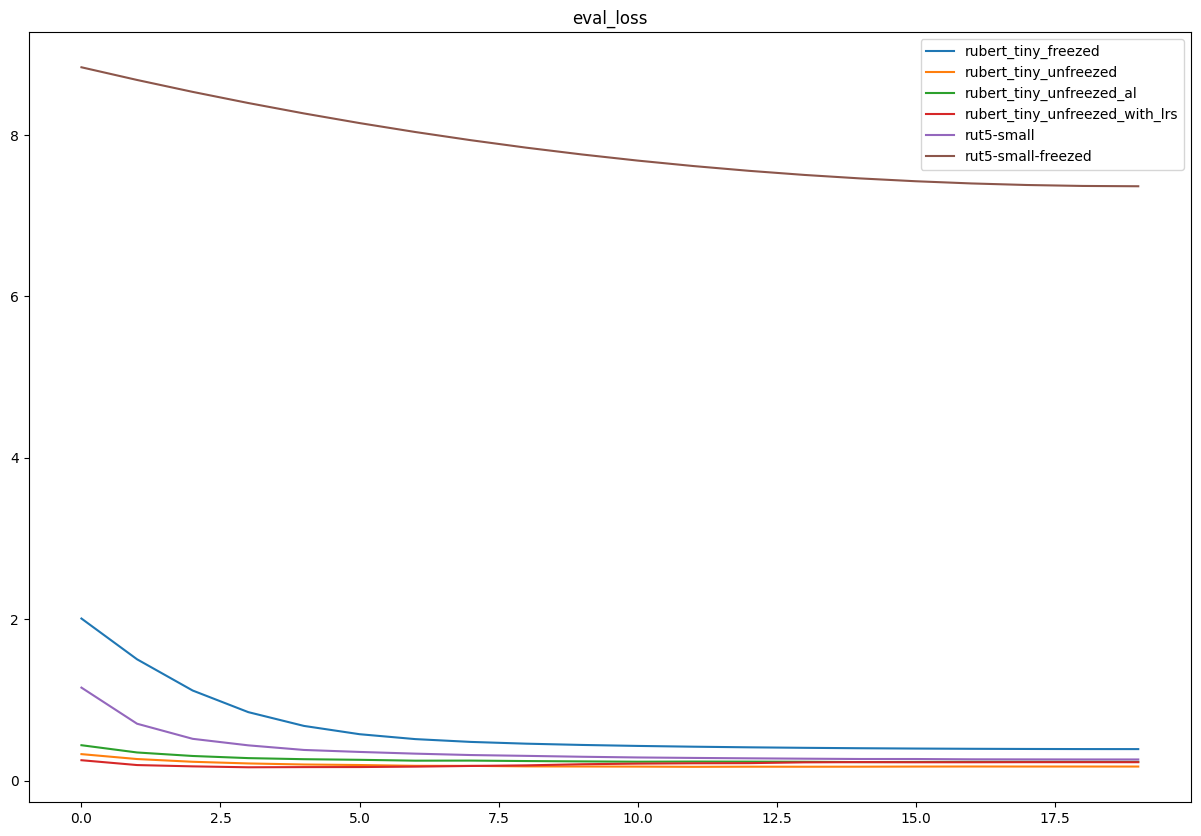

In [46]:
full_hist.plot(title="eval_loss", figsize=[15,10])

<Axes: title={'center': 'eval_loss'}>

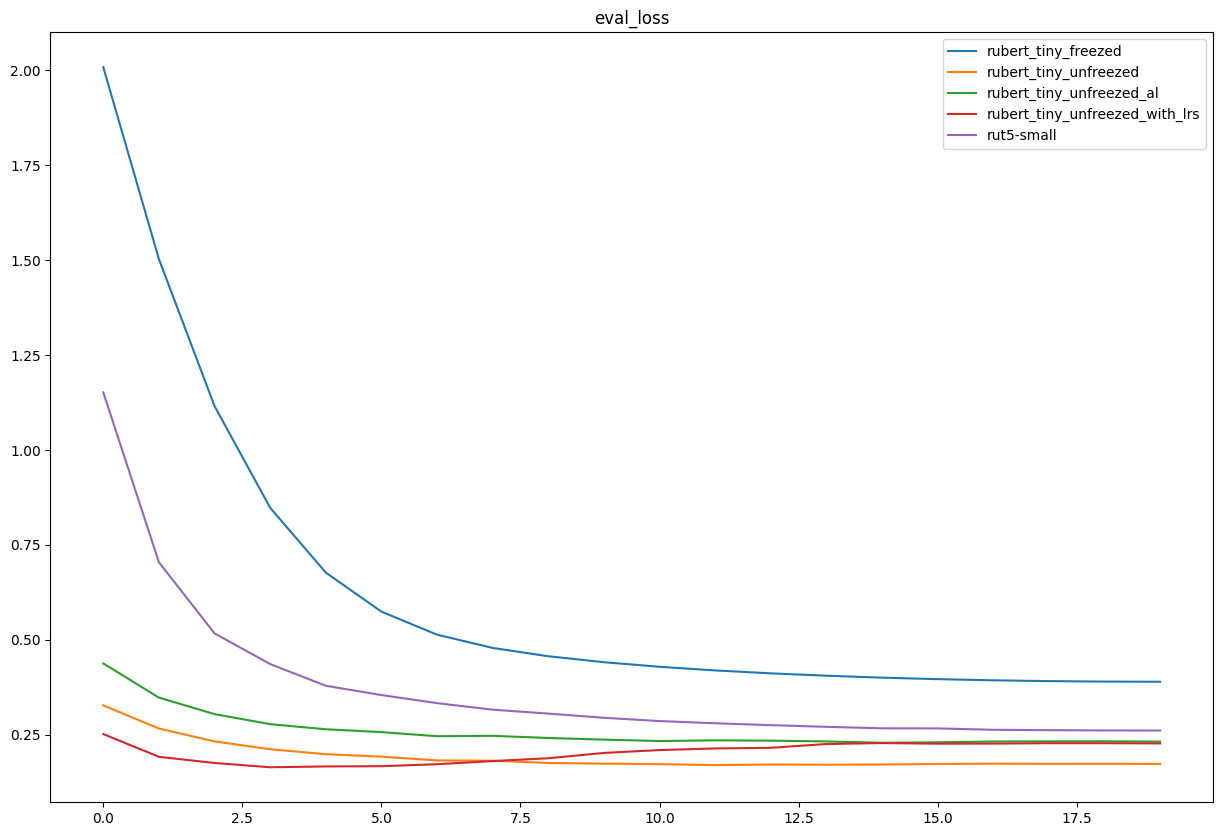

In [49]:
#отрисую без замороженной Т5 чтобы было видно остальных
full_hist.drop("rut5-small-freezed", axis=1).plot(title="eval_loss", figsize=[15,10])